# 02 - Boruta experiment 1

**Objectives:**
* test the **boruta** feature selection on the logcpm expression matrix
* `pip install boruta`
* see: https://github.com/scikit-learn-contrib/boruta_py
* paper: https://www.jstatsoft.org/article/view/v036i11

In [4]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

sns.set(style="whitegrid")

---

### Load the data

In [5]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [6]:
meta_df = pd.read_parquet(meta_path)

In [7]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

CPU times: user 1.02 s, sys: 4.33 s, total: 5.35 s
Wall time: 5.35 s


In [8]:
logcpm_df.index.name = 'spot_UID'

In [9]:
logcpm_df.reset_index(inplace=True)

In [10]:
def add_slide_ID(df):
    df['slide_ID'] = df['spot_UID'].apply(lambda x: str(x).split('__')[0])
    
    return df

In [11]:
logcpm_df = add_slide_ID(logcpm_df)

In [12]:
logcpm_df.head()

spot_UID  -343C11.2  00R_AC107638.2  0610005C13Rik  0610006L08Rik  \
0  N05_C2__20_6   2.982974        2.982974       2.982974       2.982974   
1  N05_C2__17_6   2.982974        2.982974       2.982974       2.982974   
2  N05_C2__16_6   2.982974        2.982974       2.982974       2.982974   
3  N05_C2__19_6   2.982974        2.982974       2.982974       2.982974   
4  N05_C2__18_6   2.982974        2.982974       2.982974       2.982974   

   0610007P14Rik  0610009B22Rik  0610009E02Rik  0610009L18Rik  0610009O20Rik  \
0       2.982974       2.982974       4.984943       2.982974       2.982974   
1       6.827059       5.924174       2.982974       2.982974       2.982974   
2       2.982974       5.609164       2.982974       2.982974       5.609164   
3       7.661385       2.982974       2.982974       2.982974       5.157746   
4       6.738947       6.738947       2.982974       2.982974       2.982974   

     ...      n-R5s93   n-R5s94   n-R5s95   n-R5s96   n-R5s97   n-R5s98  \
0    ...     2.982974  2.982974  2.982974  2.982974  2.982974  2.982974   
1    ...     2.982974  2.982974  2.982974  2.982974  2.982974  2.982974   
2    ...     2.982974  2.982974  2.982974  2.982974  2.982974  2.982974   
3    ...     2.982974  2.982974  2.982974  2.982974  2.982974  2.982974   
4    ...     2.982974  2.982974  2.982974  2.982974  2.982974  2.982974   

   n-TSaga9  n-TStga1  sampleID  slide_ID  
0  2.982974  2.982974    N05_C2    N05_C2  
1  2.982974  2.982974    N05_C2    N05_C2  
2  2.982974  2.982974    N05_C2    N05_C2  
3  2.982974  2.982974    N05_C2    N05_C2  
4  2.982974  2.982974    N05_C2    N05_C2  

[5 rows x 46457 columns]

In [13]:
st_df = logcpm_df.merge(meta_df, how='inner', on='spot_UID')

In [14]:
st_df.head()

spot_UID  -343C11.2  00R_AC107638.2  0610005C13Rik  0610006L08Rik  \
0  N05_C2__20_6   2.982974        2.982974       2.982974       2.982974   
1  N05_C2__17_6   2.982974        2.982974       2.982974       2.982974   
2  N05_C2__16_6   2.982974        2.982974       2.982974       2.982974   
3  N05_C2__19_6   2.982974        2.982974       2.982974       2.982974   
4  N05_C2__18_6   2.982974        2.982974       2.982974       2.982974   

   0610007P14Rik  0610009B22Rik  0610009E02Rik  0610009L18Rik  0610009O20Rik  \
0       2.982974       2.982974       4.984943       2.982974       2.982974   
1       6.827059       5.924174       2.982974       2.982974       2.982974   
2       2.982974       5.609164       2.982974       2.982974       5.609164   
3       7.661385       2.982974       2.982974       2.982974       5.157746   
4       6.738947       6.738947       2.982974       2.982974       2.982974   

    ...    endothelial  interneuron  slide_ID_y  region  sampleID_y  GT  \
0   ...       0.095625     0.106595      N05_C2  AT_OLF      N05_C2  KI   
1   ...      -0.014931     0.049969      N05_C2  AT_OLF      N05_C2  KI   
2   ...      -0.049142    -0.042531      N05_C2  AT_OLF      N05_C2  KI   
3   ...       0.057104     0.143494      N05_C2  AT_OLF      N05_C2  KI   
4   ...       0.043532     0.098493      N05_C2  AT_OLF      N05_C2  KI   

   age_days  age_months  age  age_GT  
0       558          18  old  old_KI  
1       558          18  old  old_KI  
2       558          18  old  old_KI  
3       558          18  old  old_KI  
4       558          18  old  old_KI  

[5 rows x 46764 columns]

In [15]:
st_df['slide_ID'] = st_df['slide_ID_y'].astype('category', copy=False)
st_df['GT'] = st_df['GT'].astype('category', copy=False)
st_df['age'] = st_df['age_GT'].astype('category', copy=False)
st_df['age_GT'] = st_df['age_GT'].astype('category', copy=False)

In [17]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

In [18]:
expression_df = st_df[gene_columns]

In [19]:
AB1_std_dev_yen = st_df[['AB1_StdDev_Yen']]

--- 

### **Boruta experiment 1**

In [20]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features='sqrt', max_depth=5)

In [21]:
def do_boruta_old(estimator, verbose=2, seed=42):
    feat_selector = BorutaPy(estimator=estimator, verbose=verbose, random_state=seed, n_estimators='auto')
    
    X = expression_df.as_matrix()
    y = AB1_std_dev_yen.values.ravel()
    feat_selector.fit(X, y)
    
    selected_columns = feat_selector.support_
    return gene_columns[selected_columns]

In [22]:
def do_boruta(estimator, verbose=2, seed=42, target='AB1_StdDev_Yen'):
    feat_selector = BorutaPy(estimator=estimator, verbose=verbose, random_state=seed)
    
    X = expression_df.as_matrix()
    y = st_df[[target]].values.ravel()
    feat_selector.fit(X, y)
        
    return feat_selector

**TODO**: clean this up

In [55]:
gene_columns[selected_columns]

Index(['B2m', 'C1qa', 'C1qb', 'C1qc', 'C4a', 'C4b', 'Ccl6', 'Cd52', 'Cd68',
       'Cd74', 'Clec7a', 'Cst3', 'Cst7', 'Ctsb', 'Ctsd', 'Ctss', 'Ctsz',
       'Fcer1g', 'Fcgr3', 'Gfap', 'Gm14173', 'Hexb', 'Itgax', 'Lag3', 'Ly86',
       'Lyz2', 'Mpeg1', 'Rplp1', 'Serpina3n', 'Sez6', 'Trem2', 'Tyrobp',
       'mt-Rnr1', 'mt-Rnr2'],
      dtype='object')

In [54]:
feat_selector.ranking_

array([29456,  8630, 29456, ..., 29456, 29456, 29456])

In [45]:
X_filtered = feat_selector.transform(X)

In [35]:
ex1_selected = ['B2m', 'C1qa', 'C1qb', 'C1qc', 'C4a', 'C4b', 'Ccl6', 'Cd52', 'Cd68',
       'Cd74', 'Clec7a', 'Cst3', 'Cst7', 'Ctsb', 'Ctsd', 'Ctss', 'Ctsz',
       'Fcer1g', 'Fcgr3', 'Gfap', 'Gm14173', 'Hexb', 'Itgax', 'Lag3', 'Ly86',
       'Lyz2', 'Mpeg1', 'Rplp1', 'Serpina3n', 'Sez6', 'Trem2', 'Tyrobp',
       'mt-Rnr1', 'mt-Rnr2']

---

### **Boruta experiment 2**

In [ ]:
%%time
ex2_selected = do_boruta(estimator=RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features=0.01, max_depth=5))

In [67]:
ex2_selected

Index(['2810433D01Rik', 'Apoe', 'B2m', 'C1qa', 'C1qb', 'C1qc', 'C3ar1', 'C4a',
       'C4b', 'Ccl3', 'Ccl6', 'Cd14', 'Cd52', 'Cd68', 'Cd74', 'Cd9', 'Clec7a',
       'Clu', 'Csf1r', 'Cst3', 'Cst7', 'Ctsb', 'Ctsd', 'Ctsl', 'Ctss', 'Ctsz',
       'Fcer1g', 'Fcgr2b', 'Fcgr3', 'Fcrls', 'Fth1', 'Gfap', 'Gm26917',
       'Gm5874', 'Gpnmb', 'H2-Aa', 'H2-D1', 'Hexa', 'Hexb', 'Itgax', 'Lag3',
       'Laptm5', 'Lgals3bp', 'Lrrc17', 'Ly86', 'Lyz1', 'Lyz2', 'Mamdc2',
       'Mpeg1', 'Olfml3', 'Olfr912', 'Plek', 'Rpl12', 'Rplp1', 'Serpina3n',
       'Sez6', 'Spp1', 'Trem2', 'Tyrobp', 'Wfdc17', 'mt-Rnr1', 'mt-Rnr2'],
      dtype='object')

In [64]:
pd.DataFrame(['2810433D01Rik', 'Apoe', 'B2m', 'C1qa', 'C1qb', 'C1qc', 'C3ar1', 'C4a',
       'C4b', 'Ccl3', 'Ccl6', 'Cd14', 'Cd52', 'Cd68', 'Cd74', 'Cd9', 'Clec7a',
       'Clu', 'Csf1r', 'Cst3', 'Cst7', 'Ctsb', 'Ctsd', 'Ctsl', 'Ctss', 'Ctsz',
       'Fcer1g', 'Fcgr2b', 'Fcgr3', 'Fcrls', 'Fth1', 'Gfap', 'Gm26917',
       'Gm5874', 'Gpnmb', 'H2-Aa', 'H2-D1', 'Hexa', 'Hexb', 'Itgax', 'Lag3',
       'Laptm5', 'Lgals3bp', 'Lrrc17', 'Ly86', 'Lyz1', 'Lyz2', 'Mamdc2',
       'Mpeg1', 'Olfml3', 'Olfr912', 'Plek', 'Rpl12', 'Rplp1', 'Serpina3n',
       'Sez6', 'Spp1', 'Trem2', 'Tyrobp', 'Wfdc17', 'mt-Rnr1', 'mt-Rnr2']).to_csv('ex2', index=None, header=None)

In [34]:
ex2_selected = ['2810433D01Rik', 'Apoe', 'B2m', 'C1qa', 'C1qb', 'C1qc', 'C3ar1', 'C4a',
       'C4b', 'Ccl3', 'Ccl6', 'Cd14', 'Cd52', 'Cd68', 'Cd74', 'Cd9', 'Clec7a',
       'Clu', 'Csf1r', 'Cst3', 'Cst7', 'Ctsb', 'Ctsd', 'Ctsl', 'Ctss', 'Ctsz',
       'Fcer1g', 'Fcgr2b', 'Fcgr3', 'Fcrls', 'Fth1', 'Gfap', 'Gm26917',
       'Gm5874', 'Gpnmb', 'H2-Aa', 'H2-D1', 'Hexa', 'Hexb', 'Itgax', 'Lag3',
       'Laptm5', 'Lgals3bp', 'Lrrc17', 'Ly86', 'Lyz1', 'Lyz2', 'Mamdc2',
       'Mpeg1', 'Olfml3', 'Olfr912', 'Plek', 'Rpl12', 'Rplp1', 'Serpina3n',
       'Sez6', 'Spp1', 'Trem2', 'Tyrobp', 'Wfdc17', 'mt-Rnr1', 'mt-Rnr2']

---

### **Boruta experiment3**

In [ ]:
%%time
ex3_selected = do_boruta(estimator=RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features=0.05, max_depth=5))

In [69]:
ex3_selected

Index(['Apoe', 'B2m', 'C1qa', 'C1qb', 'C1qc', 'C4a', 'C4b', 'Ccl6', 'Cd52',
       'Cd68', 'Cd74', 'Clec7a', 'Cst3', 'Cst7', 'Ctsb', 'Ctsd', 'Ctss',
       'Ctsz', 'Fcer1g', 'Fcgr3', 'Gfap', 'Hexa', 'Hexb', 'Itgax', 'Lag3',
       'Laptm5', 'Ly86', 'Lyz1', 'Lyz2', 'Mpeg1', 'Serpina3n', 'Sez6', 'Trem2',
       'Tyrobp', 'mt-Rnr1', 'mt-Rnr2'],
      dtype='object')

In [33]:
ex3_selected = ['Apoe', 'B2m', 'C1qa', 'C1qb', 'C1qc', 'C4a', 'C4b', 'Ccl6', 'Cd52',
       'Cd68', 'Cd74', 'Clec7a', 'Cst3', 'Cst7', 'Ctsb', 'Ctsd', 'Ctss',
       'Ctsz', 'Fcer1g', 'Fcgr3', 'Gfap', 'Hexa', 'Hexb', 'Itgax', 'Lag3',
       'Laptm5', 'Ly86', 'Lyz1', 'Lyz2', 'Mpeg1', 'Serpina3n', 'Sez6', 'Trem2',
       'Tyrobp', 'mt-Rnr1', 'mt-Rnr2']

---

### **Boruta experiment6**

In [ ]:
%%time
ex6_selected = do_boruta(estimator=RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features=0.1, max_depth=5))

In [291]:
gene_columns[ex6_selected.support_]

Index(['B2m', 'C1qa', 'C1qb', 'C1qc', 'C4b', 'Ccl6', 'Cd68', 'Cd74', 'Clec7a',
       'Cst7', 'Ctsb', 'Ctsd', 'Ctss', 'Ctsz', 'Gfap', 'Hexb', 'Itgax', 'Ly86',
       'Lyz2', 'Mpeg1', 'Serpina3n', 'Sez6', 'Trem2', 'Tyrobp', 'mt-Rnr1',
       'mt-Rnr2'],
      dtype='object')

---

### **Boruta experiment 7**

In [ ]:
%%time
ex7_selected = do_boruta(estimator=RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features=0.005, max_depth=5))

In [314]:
ex7_genes = gene_columns[ex7_selected.support_]
ex7_genes

Index(['2810433D01Rik', 'Apoe', 'B2m', 'C1qa', 'C1qb', 'C1qc', 'C3ar1', 'C4a',
       'C4b', 'Ccl3', 'Ccl6', 'Cd14', 'Cd52', 'Cd68', 'Cd74', 'Cd9', 'Clec7a',
       'Clu', 'Csf1r', 'Cst3', 'Cst7', 'Ctsb', 'Ctsd', 'Ctsl', 'Ctss', 'Ctsz',
       'Cxcl5', 'Fcer1g', 'Fcgr2b', 'Fcgr3', 'Fcrls', 'Fth1', 'Gfap',
       'Gm28437', 'Gm7079', 'Gpnmb', 'Grn', 'H2-Aa', 'H2-D1', 'Hexa', 'Hexb',
       'Irf8', 'Itgax', 'Itgb5', 'Kif15', 'Lag3', 'Laptm5', 'Lgals3bp',
       'Lrrc17', 'Ly86', 'Lyz1', 'Lyz2', 'Mamdc2', 'Mpeg1', 'Olfml3',
       'Olfr912', 'Plek', 'Rplp1', 'Rps12', 'Serpina3n', 'Sez6', 'Slc6a3',
       'Spp1', 'Trem2', 'Tyrobp', 'Wfdc17', 'mt-Rnr1', 'mt-Rnr2'],
      dtype='object')

---

### **Boruta experiment 8**

In [ ]:
%%time
ex8_as_selected = do_boruta(estimator=RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features=0.005, max_depth=5),
                            target='AS1_StdDev')

In [24]:
ex8_genes = gene_columns[ex8_as_selected.support_]
ex8_genes

Index(['1810041L15Rik', '2810433D01Rik', '9330162G02Rik', 'AC149090.1', 'Aatk',
       'Ache', 'Anapc2', 'Ank3', 'Apoe', 'Aqp4',
       ...
       'mt-Tl1', 'mt-Tl2', 'mt-Tm', 'mt-Tn', 'mt-Tp', 'mt-Tq', 'mt-Ts2',
       'mt-Tt', 'mt-Tv', 'mt-Tw'],
      dtype='object', length=304)

In [30]:
pd.DataFrame(ex8_genes).to_csv('ex8_AS1.txt', index=None, header=None)

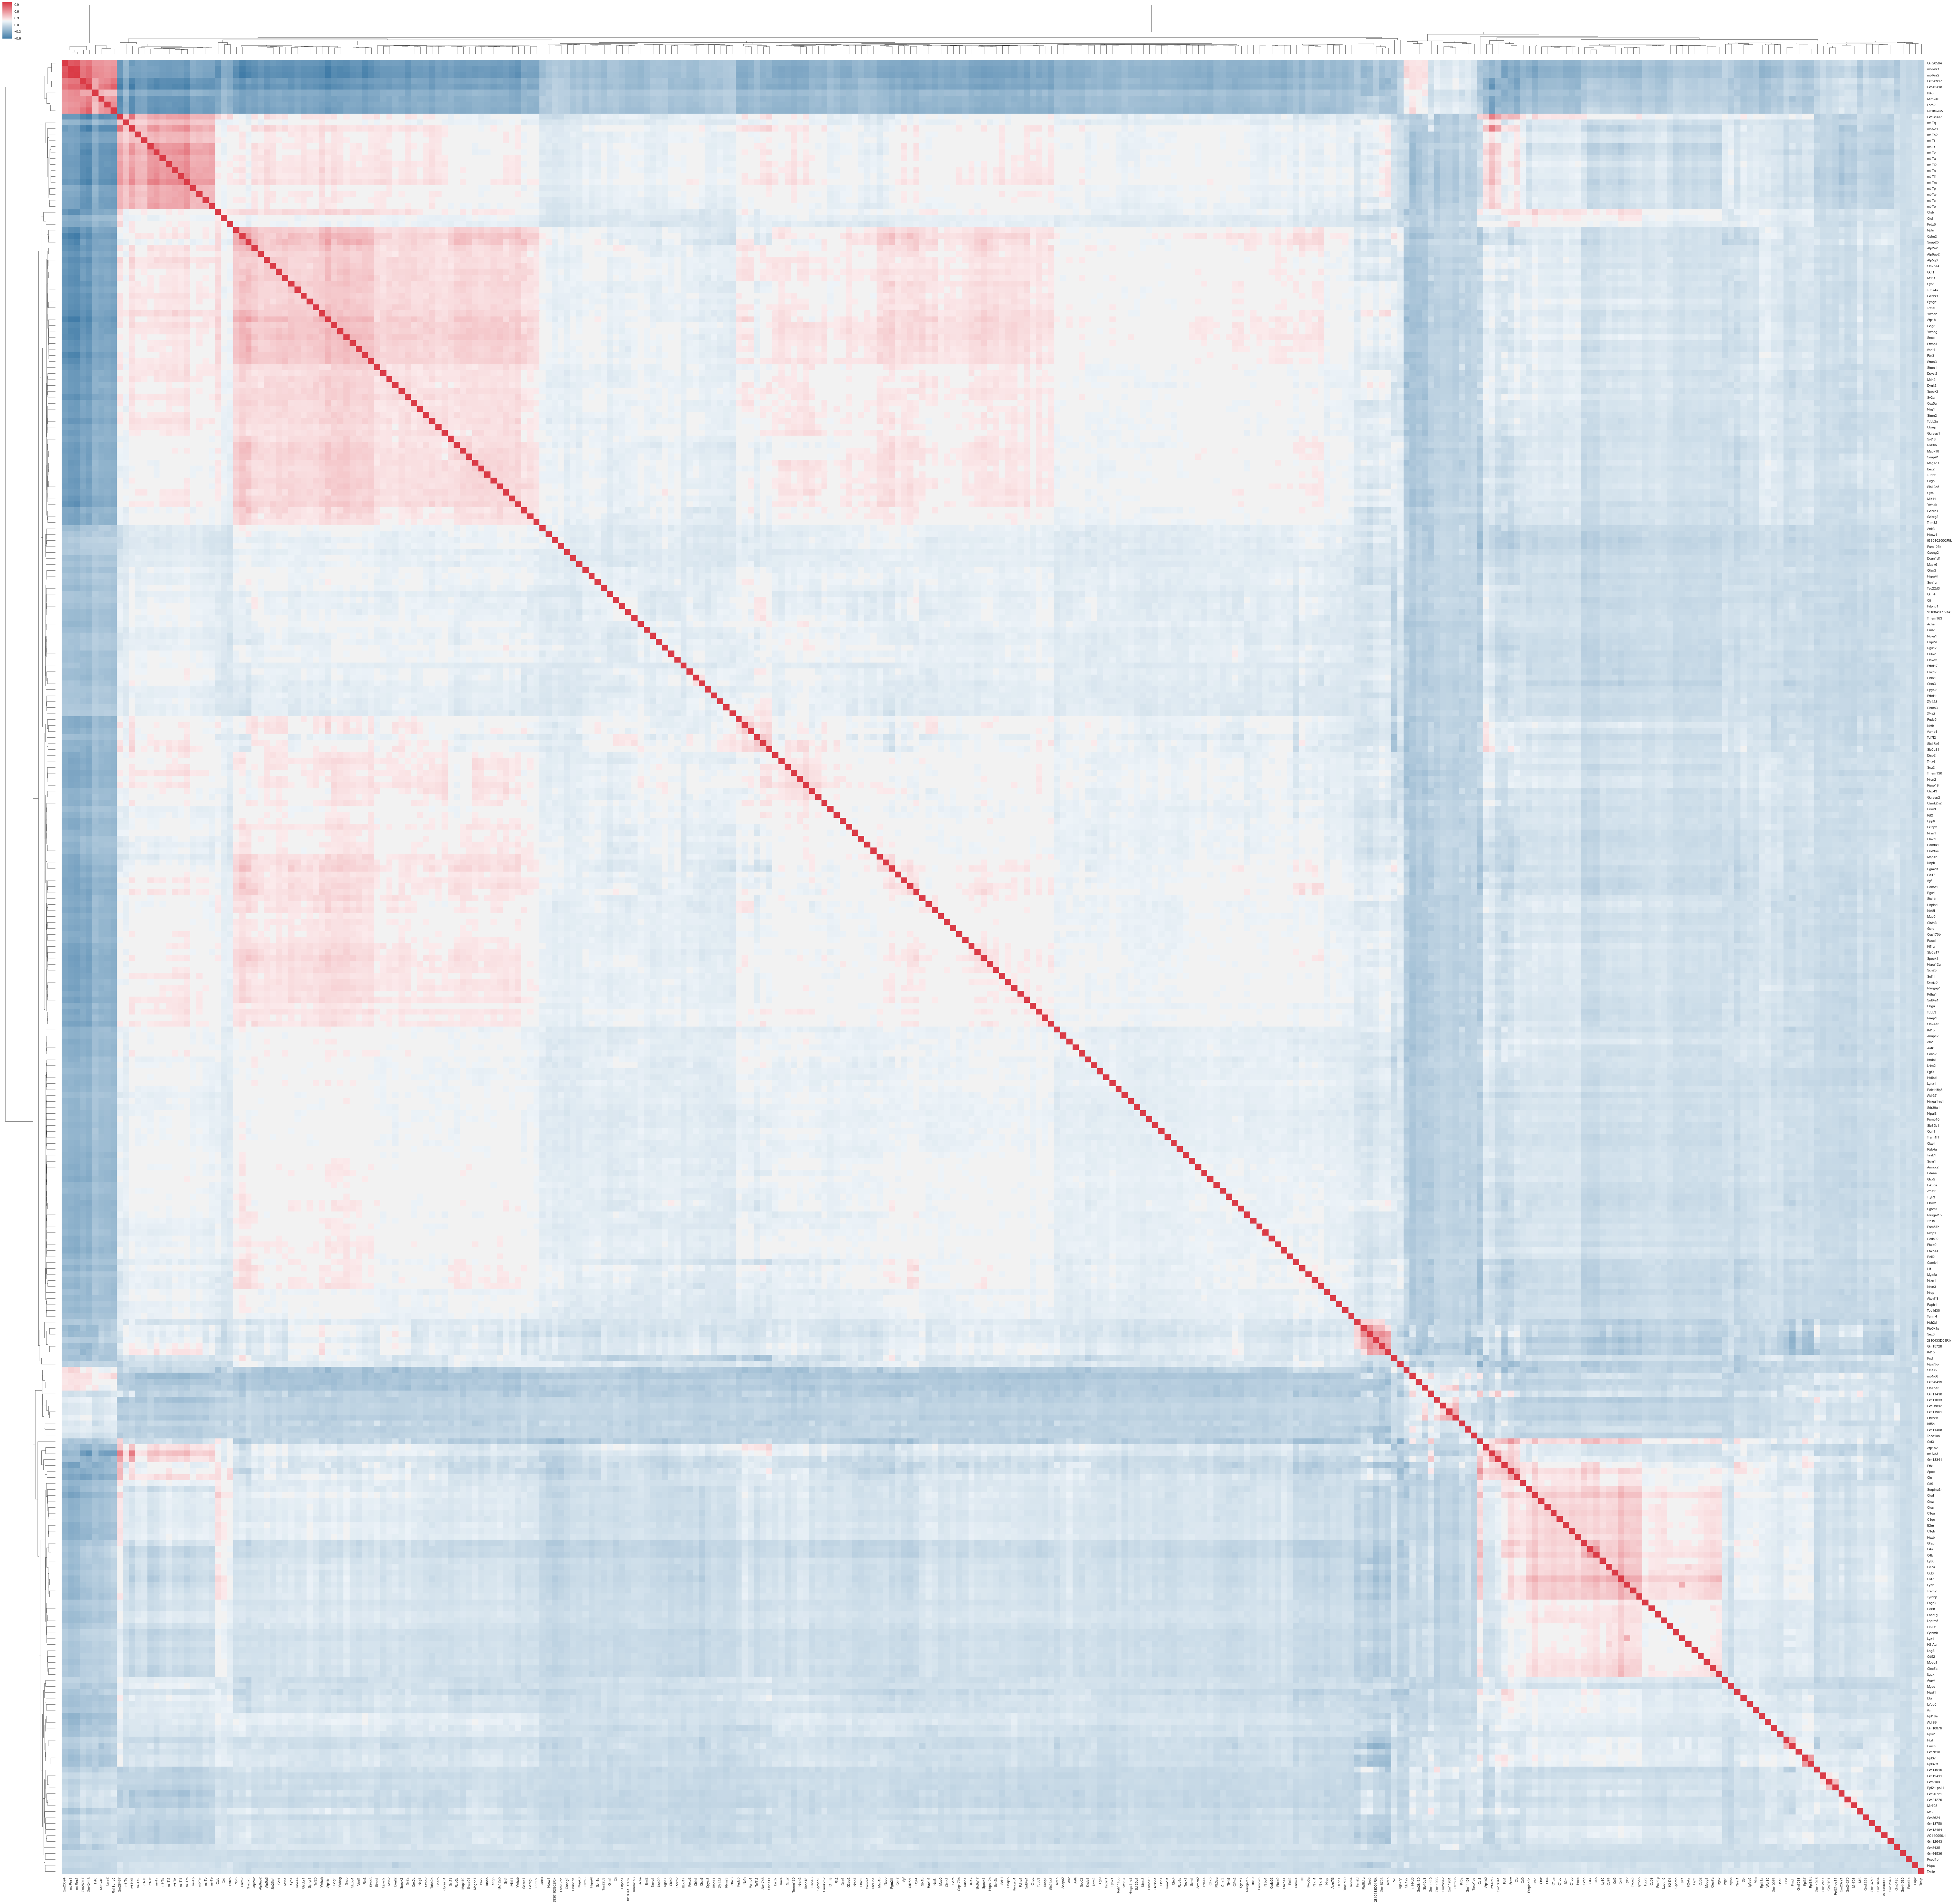

In [37]:
corr = st_df[ex8_genes].corr()
# f, ax = plt.subplots(figsize=(18, 16))
sns.clustermap(corr, cmap=sns.diverging_palette(240, 10, as_cmap=True), figsize=(100, 100))
plt.savefig('boruta_AS1_heatmap.png')
plt.show()

---

### **Boruta experiment 9**

In [ ]:
%%time
ex9_as_selected = do_boruta(estimator=RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features=0.005, max_depth=5),
                            target='AS2_StdDev')

In [32]:
ex9_genes = gene_columns[ex9_as_selected.support_]
ex9_genes

Index(['1500009C09Rik', '1810041L15Rik', '2810433D01Rik', '9330162G02Rik',
       'AC149090.1', 'Aatk', 'Ache', 'Apoe', 'Aqp4', 'Armcx2',
       ...
       'mt-Te', 'mt-Tf', 'mt-Tl1', 'mt-Tl2', 'mt-Tm', 'mt-Tn', 'mt-Tp',
       'mt-Ts2', 'mt-Tv', 'mt-Tw'],
      dtype='object', length=238)

In [33]:
pd.DataFrame(ex9_genes).to_csv('ex9_AS1.txt', index=None, header=None)

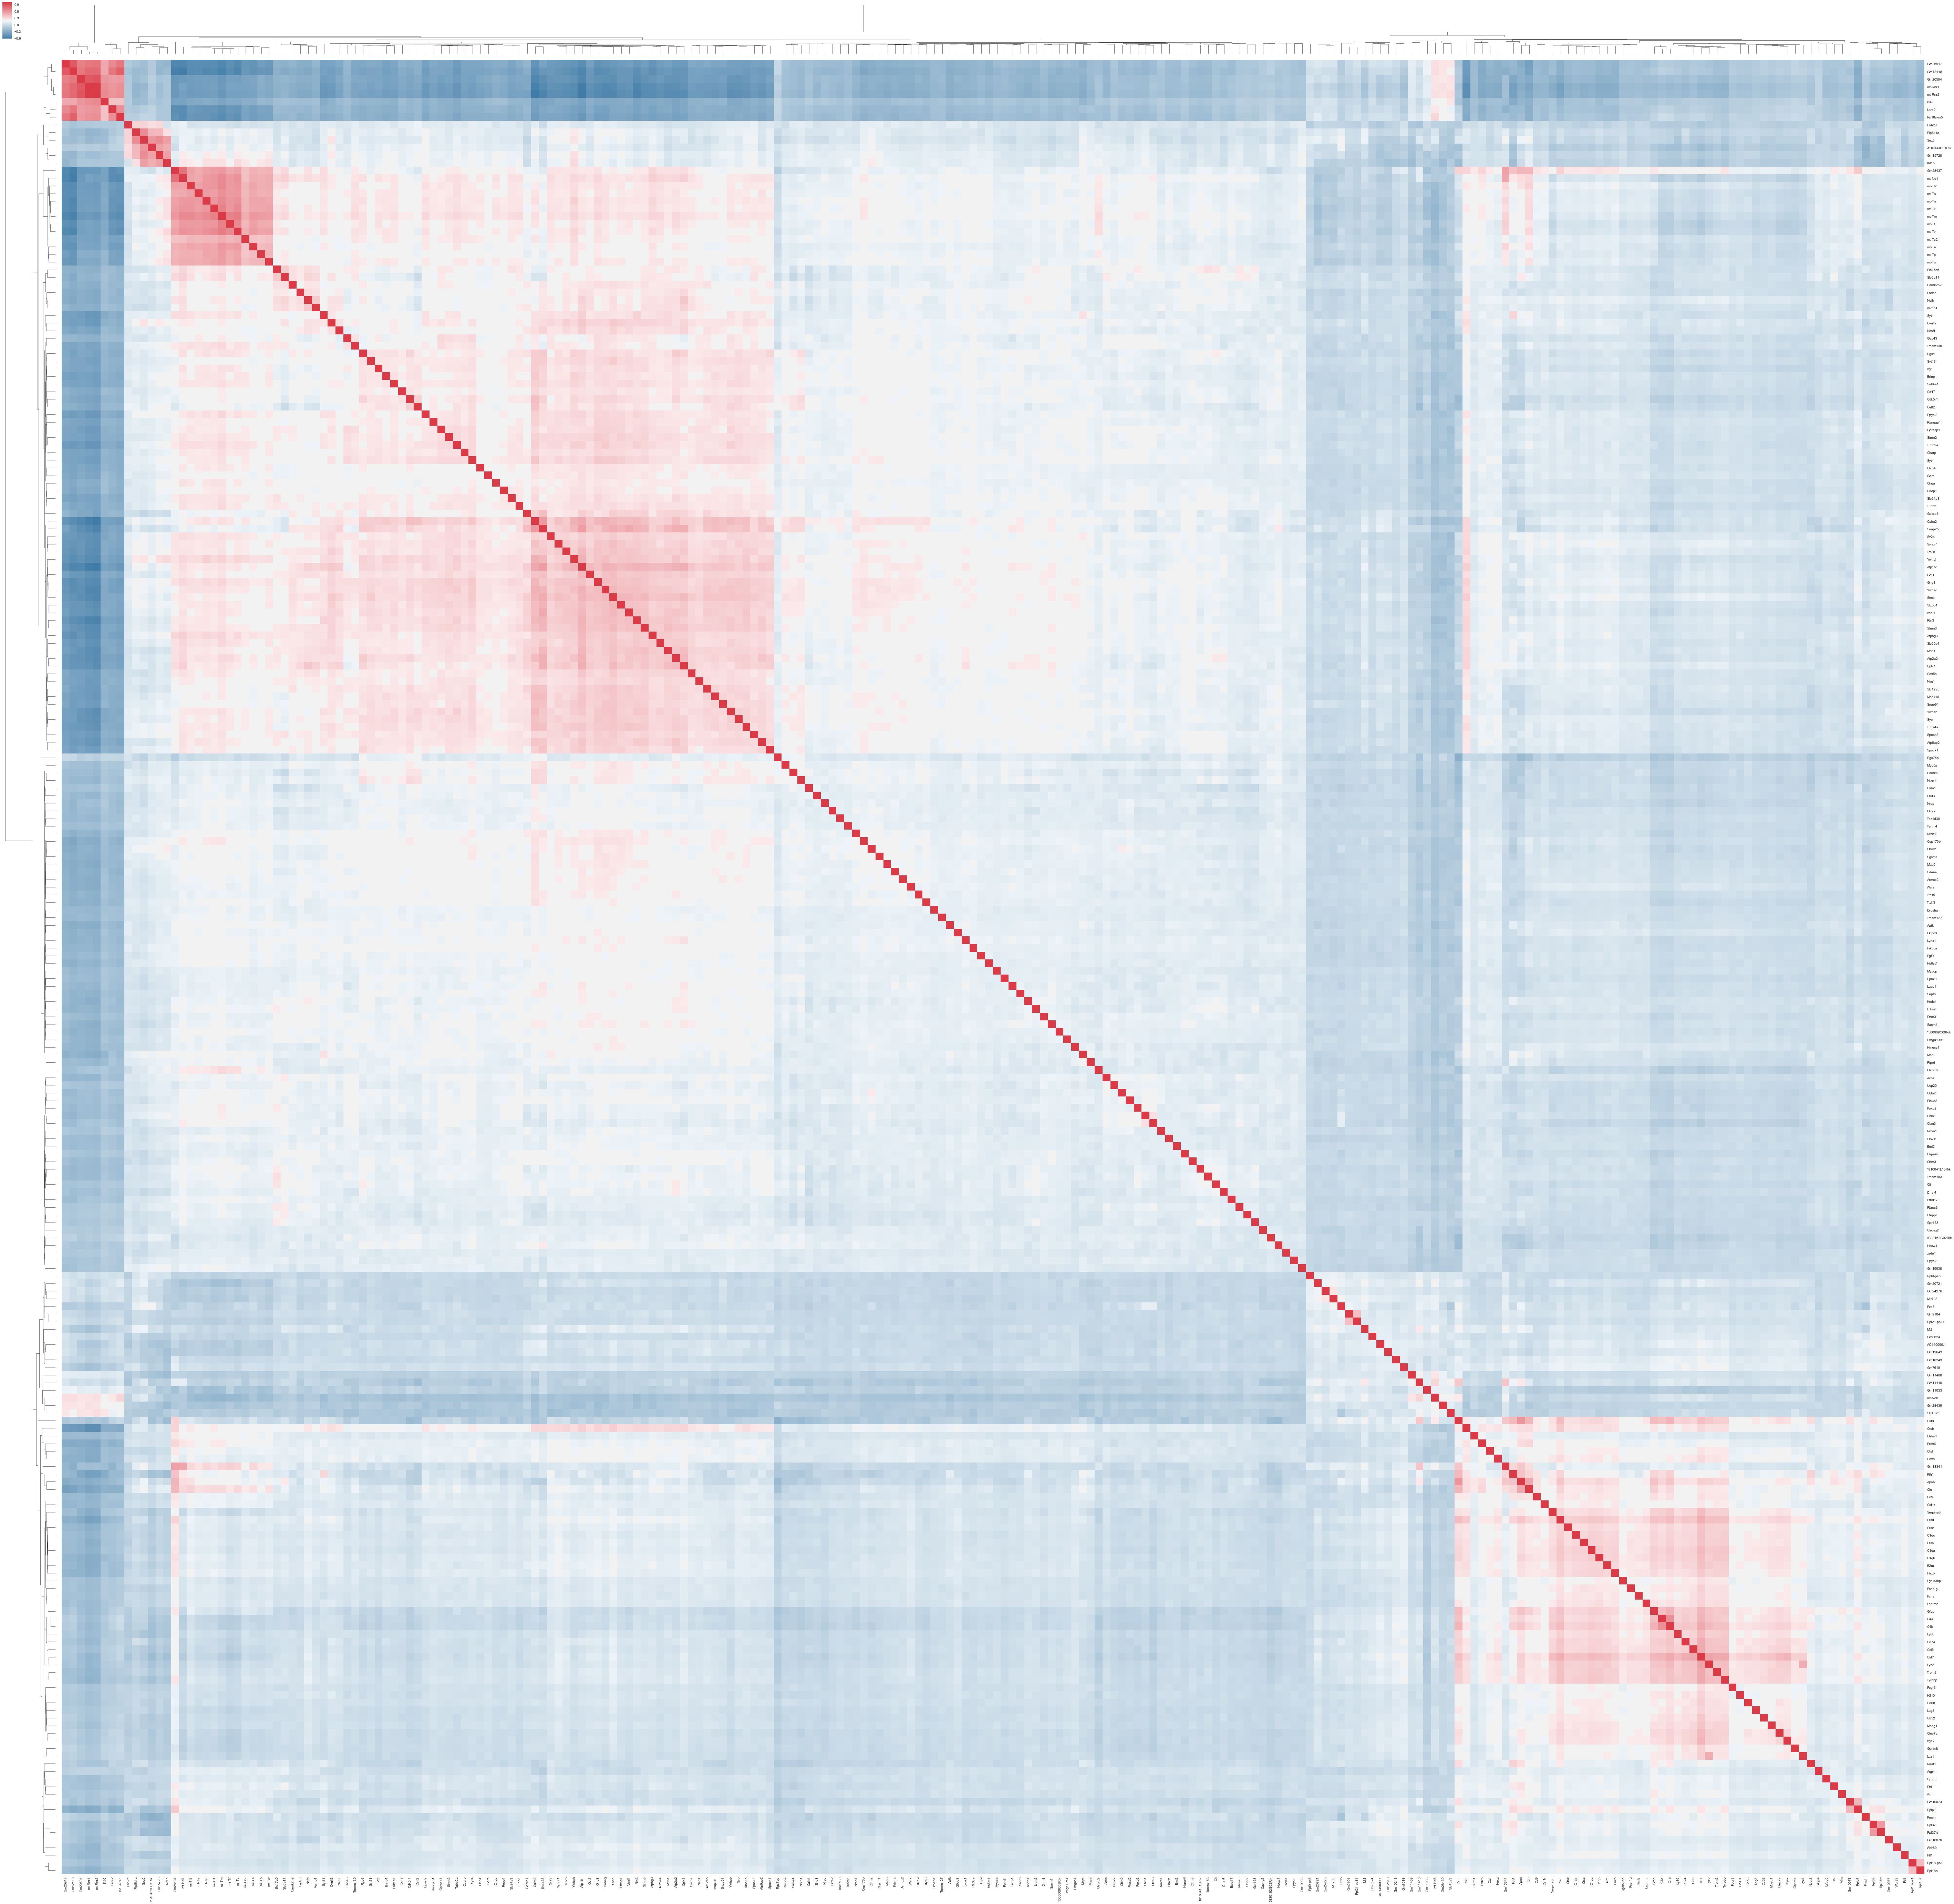

In [34]:
corr = st_df[ex9_genes].corr()
# f, ax = plt.subplots(figsize=(18, 16))
sns.clustermap(corr, cmap=sns.diverging_palette(240, 10, as_cmap=True), figsize=(100, 100))
plt.savefig('boruta_ex9_AS2_heatmap.png')
plt.show()

In [35]:
len(ex8_genes)

304

In [36]:
len(ex9_genes)

238

In [39]:
a = set.intersection(set(ex8_genes), set(ex9_genes))

In [42]:
set.difference(set(ex9_genes), set(ex8_genes))

{'1500009C09Rik',
 'Brinp1',
 'Caln1',
 'Celf2',
 'Clcn4',
 'Cplx1',
 'Csf1r',
 'Drosha',
 'Ehd3',
 'Elovl6',
 'Etnppl',
 'Fcrls',
 'Ftl1',
 'Fzd5',
 'G6pc3',
 'Gabrb2',
 'Gfra2',
 'Gm10073',
 'Gm10243',
 'Gm19938',
 'Gpr153',
 'Gstm1',
 'Hexa',
 'Hmgcs1',
 'Jade1',
 'Lgals3bp',
 'Luzp1',
 'Mapt',
 'Mypop',
 'Ppm1l',
 'Ptprd',
 'Rpl18-ps1',
 'Rpl9-ps6',
 'Rplp1',
 'Sacm1l',
 'Sept6',
 'Syp',
 'Syt11',
 'Tmem127',
 'Wars',
 'Zmat4'}

---

# **HITS**

references to Alzheimer related papers with one of the selected genes

* **Fcer1g**
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3677161/
* **Lyz2**
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4198361/
* **Hexb**
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2612729/
* **B2m**
    * https://www.nature.com/articles/nm.3898
* **Serpina3n**
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1609963/
* **Trem2**
    * https://www.ncbi.nlm.nih.gov/pubmed/28426958
* **Sez6**
    * https://molecularneurodegeneration.biomedcentral.com/articles/10.1186/s13024-016-0134-z
* **Cst3**
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3390601/
* **Tyrobp**
    * https://www.ncbi.nlm.nih.gov/gene/7305

---

# Gradient Boosting yay!

* TODO: use a stochastic GBM regressor
* http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/


**Observations:**
* much slower, not well parallelizable..
* no apparent added value

In [29]:
from sklearn.base import BaseEstimator, RegressorMixin
from abc import ABCMeta

EARLY_STOP_WINDOW_LENGTH = 25

DEFAULT_SGBM_KWARGS = {    
    'learning_rate': 0.01,
    'n_estimators': 10000,  # can be arbitrarily large
    'max_features': 0.1,
    'subsample': 0.9
}

class EarlyStopMonitor:

    def __init__(self, window_length=EARLY_STOP_WINDOW_LENGTH):        
        self.window_length = window_length

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, regressor, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(regressor.oob_improvement_[lo: hi]) < 0
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False
        
class StochasticGradientBoostingRegressor(BaseEstimator, RegressorMixin, metaclass=ABCMeta):
    
    def __init__(self, sgbm_kwargs=DEFAULT_SGBM_KWARGS, monitor=EarlyStopMonitor(), random_state=42):
        self.sgbm = GradientBoostingRegressor(random_state=42, **sgbm_kwargs)
        self.monitor = monitor
        
    def fit(self, X, y):
        if self.monitor:
            self.sgbm.fit(X, y, monitor=self.monitor)            
        else:
            self.sgbm.fit(X, y)
            
        return self    
    
    def score(self, X, y, sample_weight=None):
        return self.score(X, y, sample_weight)
    
    def get_params(self, deep=True):
        return self.sgbm.get_params(deep)
    
    def set_params(self, **params):
        self.sgbm.set_params(**params) 
                
    @property    
    def feature_importances_(self):
        return self.sgbm.feature_importances_

In [30]:
sgbm = StochasticGradientBoostingRegressor()

In [ ]:
%%time
ex4_selected = do_boruta(estimator=sgbm)

In [32]:
ex4_selected

Index(['B2m', 'C1qa', 'C1qb', 'C1qc', 'Ccl6', 'Cd68', 'Cd74', 'Clec7a', 'Cst7',
       'Ctsb', 'Ctsd', 'Ctsz', 'Fcer1g', 'Gfap', 'Gm37080', 'Hexb', 'Itgax',
       'Lyz2', 'Mpeg1', 'Serpina3n', 'Sez6', 'Trem2', 'Tyrobp', 'mt-Rnr1',
       'mt-Rnr2'],
      dtype='object')

In [51]:
ex1_df = pd.DataFrame(ex1_selected, columns=['ex1'])
ex4_df = pd.DataFrame(ex4_selected, columns=['ex4'])

### Random Forest clustering

* https://www.ayasdi.com/blog/bigdata/how-tda-and-machine-learning-enhance-each-other/
* https://github.com/joshloyal/RandomForestClustering/blob/master/test.py
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html

### Partial dependence plots

**Refs:**
* Sklearn PDP http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html
* SauceCat PDP box https://github.com/SauceCat/PDPbox
* SauceCat Medium article: https://towardsdatascience.com/introducing-pdpbox-2aa820afd312

In [1]:
corr = st_df[ex7_genes].corr()
# f, ax = plt.subplots(figsize=(18, 16))
sns.clustermap(corr, cmap=sns.diverging_palette(240, 10, as_cmap=True), figsize=(20, 20))
plt.savefig('boruta_heatmap.png')
plt.show()

NameError: name 'st_df' is not defined

In [171]:
from umap import UMAP

In [172]:
def umap_minkowski(ex_matrix):
    return UMAP(n_neighbors=5,
                min_dist=0.3, 
                spread=1,
                random_state=666,
                metric='minkowski',
                metric_kwds={'p': 0.5}).fit_transform(ex_matrix)

In [173]:
def umap_euclidean(ex_matrix):
    return UMAP(n_neighbors=5,
                min_dist=0.3, 
                spread=1,
                random_state=666,
                metric='euclidean').fit_transform(ex_matrix)

In [273]:
def umap_cosine(ex_matrix):
    return UMAP(n_neighbors=5,
                min_dist=0.3, 
                spread=1,
                random_state=666,
                metric='cosine').fit_transform(ex_matrix)

In [187]:
def umap_manhattan(ex_matrix):
    return UMAP(n_neighbors=5,
                min_dist=0.3, 
                spread=1,
                random_state=666,
                metric='manhattan').fit_transform(ex_matrix)

In [245]:
def plot_embedding(umap_embedding):
    embedding_df = pd.DataFrame(umap_embedding, columns=['x', 'y'])
    
    fig, axes = plt.subplots(1, 5, figsize=(48, 8))
    
    marker_size=2
    
    g1 = embedding_df.plot.scatter(ax=axes[0], x='x', y='y', s=marker_size, alpha=1, c=st_df['GT'].cat.codes, cmap=plt.cm.get_cmap('tab20', 2))
    g2 = embedding_df.plot.scatter(ax=axes[1], x='x', y='y', s=marker_size, alpha=1, c=st_df['age'].cat.codes, cmap=plt.cm.get_cmap('Set1', 2))
    g3 = embedding_df.plot.scatter(ax=axes[2], x='x', y='y', s=marker_size, alpha=1, c=st_df['age_GT'].cat.codes, cmap=plt.cm.get_cmap('tab20', 4))
    g4 = embedding_df.plot.scatter(ax=axes[3], x='x', y='y', s=marker_size, alpha=1, c=st_df['slide_ID'].cat.codes, cmap=plt.cm.get_cmap('tab20'))    
    g5 = embedding_df.plot.scatter(ax=axes[4], x='x', y='y', s=marker_size, alpha=1, c=st_df['AB1_StdDev_Yen'], cmap=plt.cm.get_cmap('magma_r'))    
    #g6 = embedding_df.plot.scatter(ax=axes[5], x='x', y='y', s=marker_size, alpha=1, c=st_df['Sez6'], cmap=plt.cm.get_cmap('magma_r'))    
    
    for g in [g1, g2, g3, g4, g5]:
        g.grid(False)
        g.set_axis_off()
        g.set_frame_on(False)
    
    plt.show()

In [246]:
%%time
ex1_manhattan = umap_manhattan(st_df[ex1_selected])
ex1_euclidean = umap_euclidean(st_df[ex1_selected])
ex1_minkowski  = umap_minkowski(st_df[ex1_selected])

CPU times: user 1min 25s, sys: 50.5 s, total: 2min 15s
Wall time: 54.2 s


In [274]:
ex2_cosine = umap_cosine(st_df[ex2_selected])

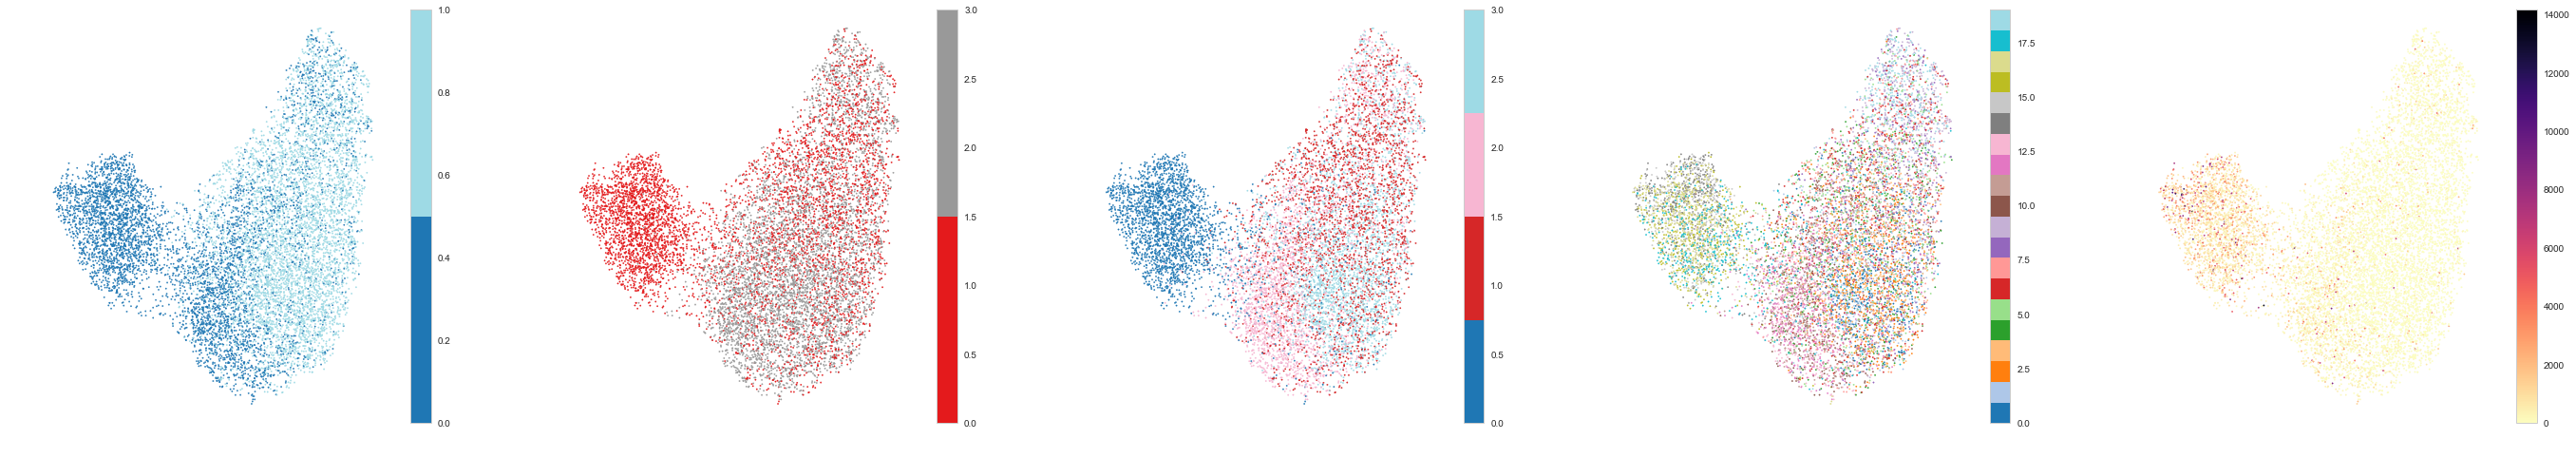

In [278]:
plot_embedding(ex1_cosine)

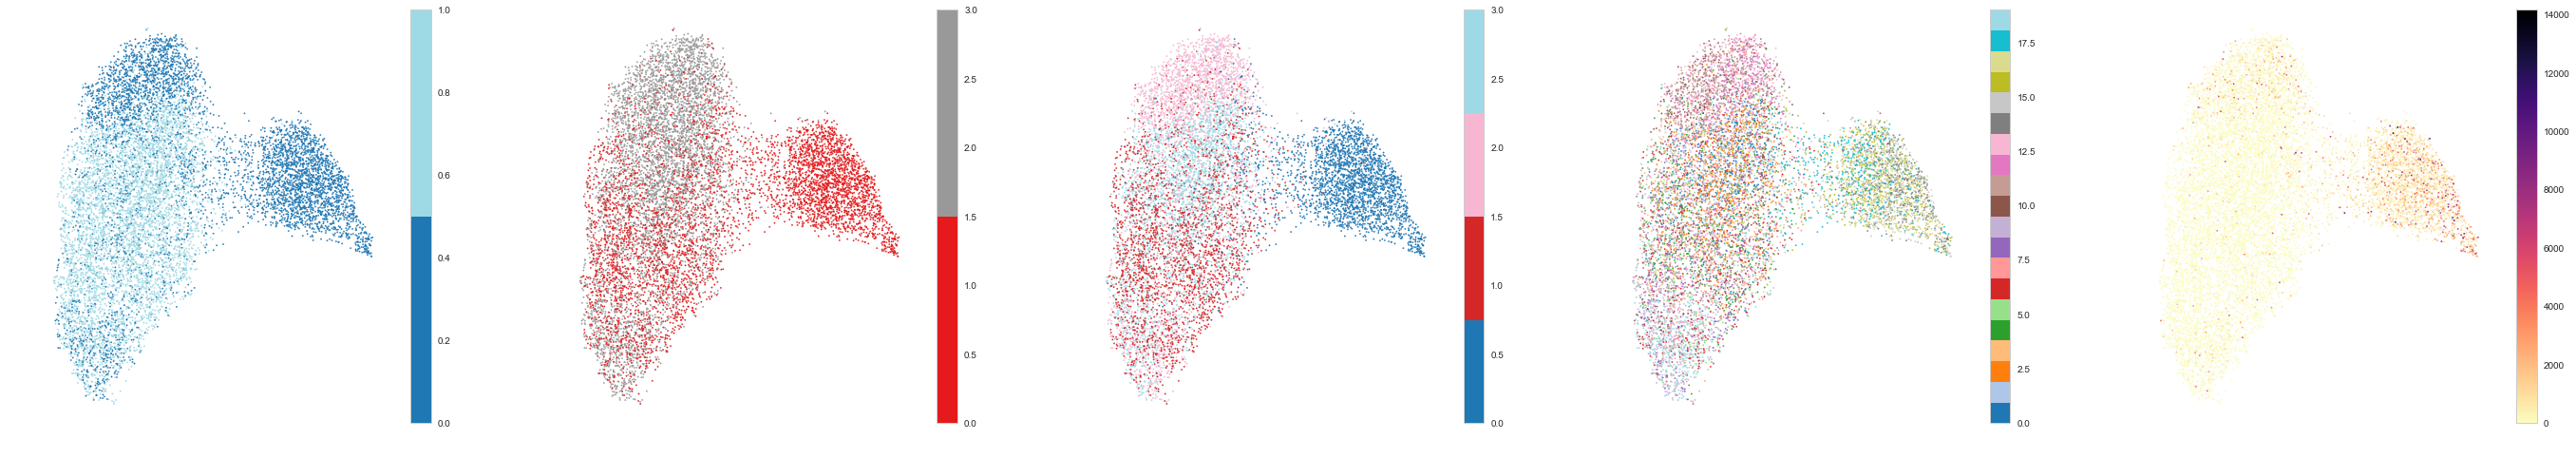

In [247]:
plot_embedding(ex1_manhattan)

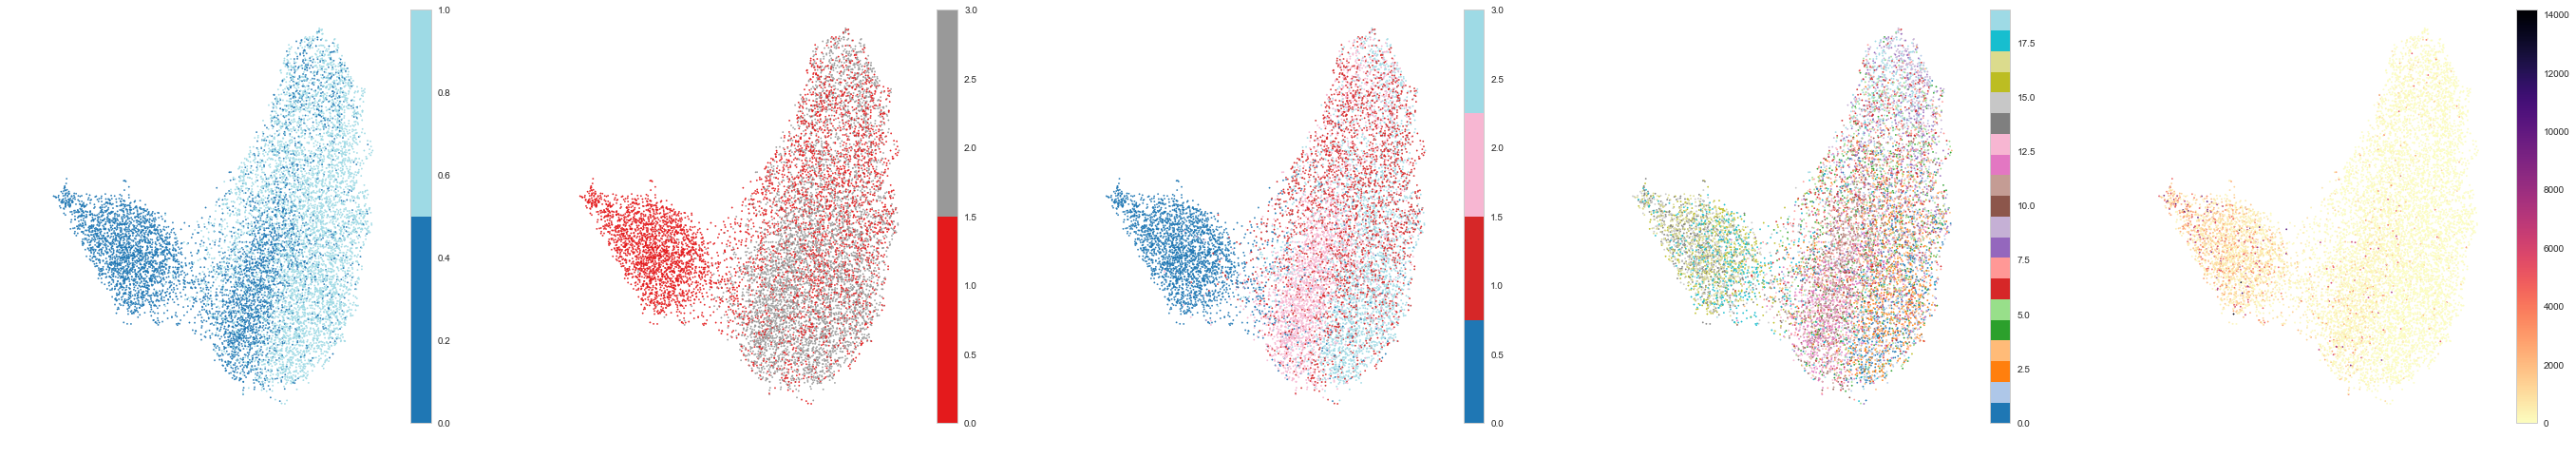

In [248]:
plot_embedding(ex1_euclidean)

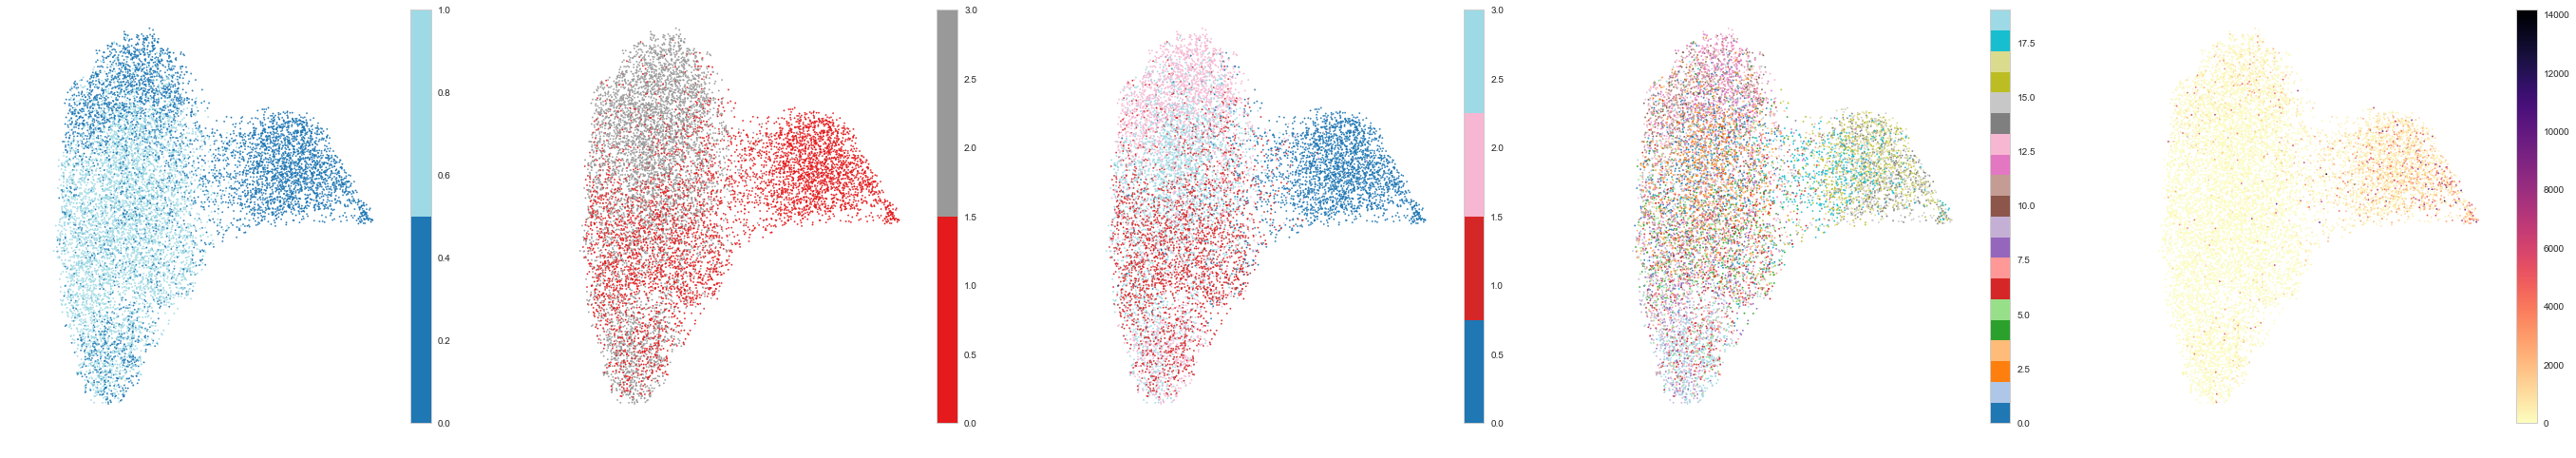

In [249]:
plot_embedding(ex1_minkowski)

In [ ]:
set.intersection(set(ex1_selected), set(ex4_selected))

In [57]:
set.difference(set(ex1_selected), set(ex4_selected))

{'C4a',
 'C4b',
 'Cd52',
 'Cst3',
 'Ctss',
 'Fcgr3',
 'Gm14173',
 'Lag3',
 'Ly86',
 'Rplp1'}

In [58]:
set.difference(set(ex4_selected), set(ex1_selected))

{'Gm37080'}

In [86]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence

In [89]:
X = expression_df.as_matrix()
y = AB1_std_dev_yen.values.ravel()

In [ ]:
gene = 'Gfap'

df = st_df[[gene, 'GT', 'AB1_StdDev_Yen']].copy()
df['GT'] = df['GT'].astype('category')

df.plot.scatter(x=gene, y='AB1_StdDev_Yen', alpha=0.5, c=df.GT.cat.codes, cmap=plt.cm.get_cmap('Set3', 2), figsize=(32,12))
plt.show()

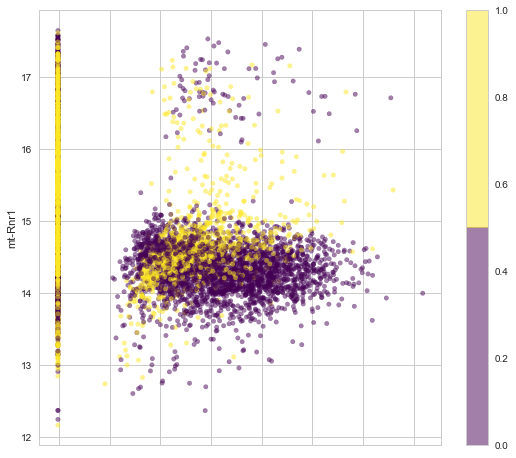

In [270]:
x = 'Lyz2'
y = 'mt-Rnr1'

df = st_df[[x, y, 'GT']].copy()
df['GT'] = df['GT'].astype('category')

df.plot.scatter(x=x, y=y, c=df.GT.cat.codes, alpha=0.5, cmap=plt.cm.get_cmap('viridis', 2), figsize=(9, 8))
plt.show()

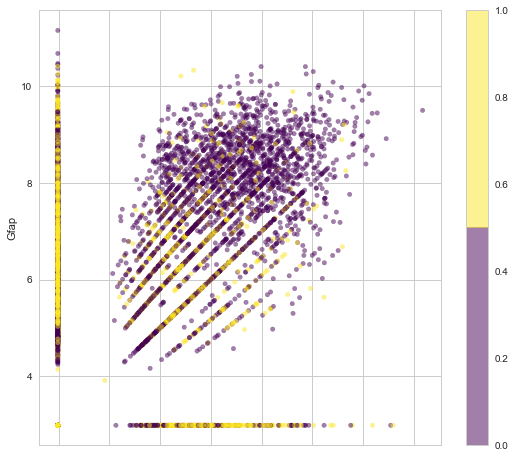

In [271]:
x = 'Lyz2'
y = 'Gfap'

df = st_df[[x, y, 'GT']].copy()
df['GT'] = df['GT'].astype('category')

df.plot.scatter(x=x, y=y, c=df.GT.cat.codes, alpha=0.5, cmap=plt.cm.get_cmap('viridis', 2), figsize=(9, 8))
plt.show()

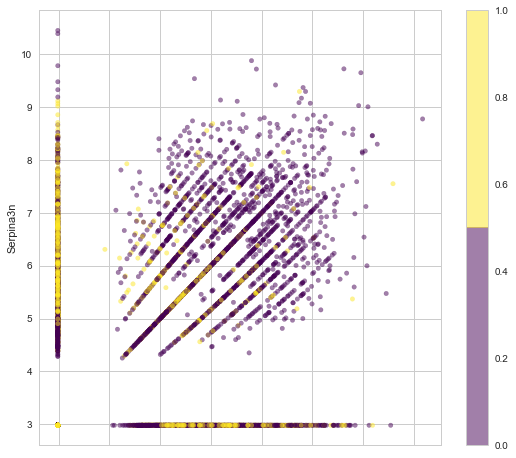

In [272]:
x = 'Lyz2'
y = 'Serpina3n'

df = st_df[[x, y, 'GT']].copy()
df['GT'] = df['GT'].astype('category')

df.plot.scatter(x=x, y=y, c=df.GT.cat.codes, alpha=0.5, cmap=plt.cm.get_cmap('viridis', 2), figsize=(9, 8))
plt.show()

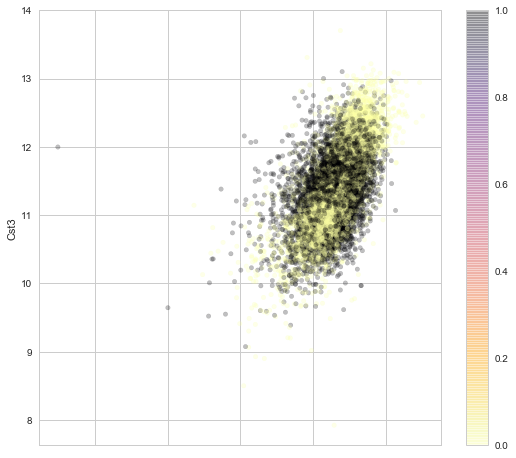

In [289]:
x = 'Apoe'
y = 'Cst3'

df = st_df[[x, y, 'GT', 'AB1_StdDev_Yen']].copy()
df['GT'] = df['GT'].astype('category')

df.plot.scatter(x=x, y=y, c=df.GT.cat.codes, alpha=0.25, cmap=plt.cm.get_cmap('inferno_r'), figsize=(9, 8))
plt.show()